In [1]:
import jax.numpy as jnp
import numpy as np
import time
import chex
import jax
import gymnasium as gym
import random
import matplotlib.pyplot as plt
import diffrax
from collections import OrderedDict
from flax.core import FrozenDict

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
import chex
from abc import ABC
from abc import abstractmethod
from exciting_environments import spaces
import diffrax
from collections import OrderedDict


class CoreEnvironment(ABC):
    """
    Description:
        Core Structure of provided Environments.

    State Variables:
        Each environment has got a list of state variables that are defined by the physical system represented.

        Example:
            ``['theta', 'omega']``

    Action Variable:
        Each environment has got an action which is applied to the physical system represented.

        Example:
            ``['torque']``

    Observation Space(State Space):
        Type: Box()
            The Observation Space is nothing but the State Space of the pyhsical system.
            This Space is a normalized, continious, multidimensional box in [-1,1].

    Action Space:
        Type: Box()
            The action space of the environments are the action spaces of the physical systems.
            This Space is a continious, multidimensional box. 


    Initial State:
        Initial state values depend on the physical system.

    """

    def __init__(self, batch_size: int, tau: float = 1e-4, solver=diffrax.Euler(), reward_func=None):
        """
        Args:
            batch_size(int): Number of training examples utilized in one iteration.
            tau(float): Duration of one control step in seconds. Default: 1e-4.
        """
        self.batch_size = batch_size
        self.tau = tau
        self._solver = solver

        if reward_func:
            if self._test_rew_func(reward_func):
                self.reward_func = reward_func
        else:
            self.reward_func = self.default_reward_func

    # @property
    # def batch_size(self):
    #     """Returns the batch size of the environment setup."""
    #     return self._batch_size

    @property
    def default_reward_function(self):
        """Returns the default reward function for the given environment."""
        return self.default_reward_func

    # @batch_size.setter
    # def batch_size(self, batch_size):
    #     # If batchsize change, update the corresponding dimension
    #     self._batch_size = batch_size

    def sim_paras(self, static_params_, env_state_constraints_, env_max_actions_):
        """Creates or updates static parameters to fit batch_size.

        Creates/Updates:
            params : Model Parameters.
        """
        static_params = static_params_.copy()
        for key, value in static_params.items():
            if jnp.isscalar(value):
                static_params[key] = jnp.full((self.batch_size), value)
                # self.static_para_dims[key] = None
            # elif jnp.all(value == value[0]):
            #     self.static_params[key] = jnp.full(
            #         (self.batch_size, 1), value[0])
            else:
                assert len(
                    value) == self.batch_size, f"{key} is expected to be a scalar or a list with len(list)=batch_size"
                static_params[key] = jnp.array(value)
                # self.static_para_dims[key] = 0

        env_state_constraints = env_state_constraints_.copy()
        for key, value in env_state_constraints.items():
            if jnp.isscalar(value):
                env_state_constraints[key] = jnp.full((self.batch_size), value)
                # self.static_para_dims[key] = None
            # elif jnp.all(value == value[0]):
            #     self.static_params[key] = jnp.full(
            #         (self.batch_size, 1), value[0])
            else:
                assert len(
                    value) == self.batch_size, f"Constraint of {key} is expected to be a scalar or a list with len(list)=batch_size"
                env_state_constraints[key] = jnp.array(value)
                # self.static_para_dims[key] = 0

        env_max_actions = env_max_actions_.copy()
        for key, value in env_max_actions.items():
            if jnp.isscalar(value):
                env_max_actions[key] = jnp.full((self.batch_size), value)
                # self.static_para_dims[key] = None
            # elif jnp.all(value == value[0]):
            #     self.static_params[key] = jnp.full(
            #         (self.batch_size, 1), value[0])
            else:
                assert len(
                    value) == self.batch_size, f"Constraint of {key} is expected to be a scalar or a list with len(list)=batch_size"
                env_max_actions[key] = jnp.array(value)
                # self.static_para_dims[key] = 0

        return static_params, OrderedDict(env_state_constraints), OrderedDict(env_max_actions)

    # def solver(self):
    #     """Returns the current solver of the environment setup."""
    #     return self._solver

    # @solver.setter
    # def solver(self, solver):
    #     # TODO:check if solver exists in diffrax ?
    #     self._solver = solver

    def _test_rew_func(self, func):
        """Checks if passed reward function is compatible with given environment.

        Args:
            func(function): Reward function to test.

        Returns:
            compatible(bool): Environment compatibility.
        """
        try:
            out = func(
                jnp.zeros([self.batch_size, int(len(self.obs_description))]))
        except:
            raise Exception(
                "Reward function should be using obs matrix as only parameter")
        try:
            if out.shape != (self.batch_size, 1):
                raise Exception(
                    "Reward function should be returning vector in shape (batch_size,1)")
        except:
            raise Exception(
                "Reward function should be returning vector in shape (batch_size,1)")
        return True

    @partial(jax.jit, static_argnums=0)
    def step(self, action, states):
        """Addtional function in step execution to enable JAX jit.

        Args:
            states(ndarray(float)): State Matrix (shape=(batch_size,states)).
            action_norm(ndarray(float)): Action Matrix (shape=(batch_size,actions)).


        Returns:
            Multiple Outputs:

            observation(ndarray(float)): Observation/State Matrix (shape=(batch_size,states)).

            reward(ndarray(float)): Amount of reward received for the last step (shape=(batch_size,1)).

            terminated(bool): Flag, indicating if Agent has reached the terminal state.

            truncated(ndarray(bool)): Flag, indicating if state has gone out of bounds (shape=(batch_size,states)).

            {}: An empty dictionary for consistency with the OpenAi Gym interface.

        """
        # ode step
        states = jax.vmap(self._ode_exp_euler_step)(
            states, action, self.static_params)

        # observation
        # print(states)
        # print(self.env_state_constraints)
        #obs = jax.vmap(self.generate_observation)(
            #states, self.env_state_constraints)
        # reward
        #reward = jax.vmap(self.reward_func)(
            #obs, action, self.env_max_actions).reshape(-1, 1)

        # bound check
        #truncated = jax.vmap(self.generate_truncated)(
            #states, self.env_state_constraints)
        #terminated = jax.vmap(self.generate_terminated)(states, reward)

        #return obs, reward, terminated, truncated, states
        return {},{},{},{},states

    @property
    @abstractmethod
    def obs_description(self):
        """Returns a list of state names of all states in the observation (equal to state space)."""
        return self.states_description

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def default_reward_func(self, obs, action):
        """Returns the default RewardFunction of the environment."""
        return

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def generate_observation(self, states):
        """Returns states."""
        return states

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def generate_truncated(self, states):
        """Returns states."""
        return

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def generate_terminated(self, states, reward):
        """Returns states."""
        return

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def _ode_exp_euler_step(self, states_norm, action_norm, state_normalizer,  action_normalizer, params):
        """Implementation of the system equations in the class with Explicit Euler.

        Args:
            states_norm(ndarray(float)): State Matrix (shape=(batch_size,states)).
            action_norm(ndarray(float)): Action Matrix (shape=(batch_size,actions)).


        Returns:
            states(ndarray(float)): State Matrix (shape=(batch_size,states)).

        """
        return

    @abstractmethod
    def reset(self, initial_values: jnp.ndarray = jnp.array([])):
        return


In [3]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
import diffrax
from collections import OrderedDict


class Pendulum(CoreEnvironment):
    """
    State Variables:
        ``['theta', 'omega']``

    Action Variable:
        ``['torque']``

    Observation Space (State Space):
        Box(low=[-1, -1], high=[1, 1])    

    Action Space:
        Box(low=-1, high=1)

    Initial State:
        Unless chosen otherwise, theta equals 1(normalized to pi) and omega is set to zero.

    Example:
        >>> import jax
        >>> import exciting_environments as excenvs
        >>> 
        >>> # Create the environment
        >>> env= excenvs.make('Pendulum-v0',batch_size=2,l=2,m=4)
        >>> 
        >>> # Reset the environment with default initial values
        >>> env.reset()
        >>> 
        >>> # Sample a random action
        >>> action = env.action_space.sample(jax.random.PRNGKey(6))
        >>> 
        >>> # Perform step
        >>> obs,reward,terminated,truncated,info= env.step(action)
        >>> 

    """

    def __init__(self, batch_size: int = 8, l: float = 1, m: float = 1,  env_max_actions: dict = {"torque": 20}, solver=diffrax.Euler(), reward_func=None, g: float = 9.81, tau: float = 1e-4, env_state_constraints: dict = {"theta": np.pi, "omega": 10}):
        """
        Args:
            batch_size(int): Number of training examples utilized in one iteration. Default: 8
            l(float): Length of the pendulum. Default: 1
            m(float): Mass of the pendulum tip. Default: 1
            max_torque(float): Maximum torque that can be applied to the system as action. Default: 20 
            reward_func(function): Reward function for training. Needs Observation-Matrix and Action as Parameters. 
                                    Default: None (default_reward_func from class) 
            g(float): Gravitational acceleration. Default: 9.81
            tau(float): Duration of one control step in seconds. Default: 1e-4.
            constraints(list): Constraints for state ['omega'] (list with length 1). Default: [10]

        Note: l,m and max_torque can also be passed as lists with the length of the batch_size to set different parameters per batch. In addition to that constraints can also be passed as a list of lists with length 1 to set different constraints per batch.  
        """
        self.env_states_name = ["theta", "omega"]
        self.env_actions_name = ["torque"]

        self.env_states_initials = {"theta": np.pi, "omega": 0}

        super().__init__(batch_size=batch_size, tau=tau,
                         solver=solver, reward_func=reward_func)

        self.static_params, self.env_state_constraints, self.env_max_actions = self.sim_paras(
            {"l": l, "m": m, "g": g}, env_state_constraints, env_max_actions)

    @partial(jax.jit, static_argnums=0)
    def _ode_exp_euler_step(self, states, action, static_params):

        env_states = states
        args = (action, static_params)

        def vector_field(t, y, args):
            theta, omega = y
            action, params = args
            d_omega = (action["torque"]+params["l"]*params["m"]*params["g"]
                       * jnp.sin(theta)) / (params["m"] * (params["l"])**2)
            d_theta = omega
            d_y = d_theta, d_omega  # [0]  # d_theta, d_omega
            return d_y

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.tau
        y0 = tuple([env_states["theta"], env_states["omega"]])
        env_state = self._solver.init(term, t0, t1, y0, args)
        y, _, _, env_state, _ = self._solver.step(
            term, t0, t1, y0, args, env_state, made_jump=False)

        theta_k1 = y[0]
        omega_k1 = y[1]
        theta_k1 = ((theta_k1+jnp.pi) % (2*jnp.pi))-jnp.pi

        # env_states_k1 = jnp.hstack((
        #     theta_k1,
        #     omega_k1,
        # ))
        env_states_k1 = dict([("theta", theta_k1), ("omega", omega_k1)]) #Ordered

        # env_states_k1_norm = env_states_k1/env_state_normalizer

        return env_states_k1

    @partial(jax.jit, static_argnums=0)
    def default_reward_func(self, obs, action, env_max_actions):
        return (obs[0])**2 + 0.1*(obs[1])**2 + 0.1*(action["torque"]/env_max_actions["torque"])**2

    @partial(jax.jit, static_argnums=0)
    def generate_observation(self, states, env_state_constraints):
        """Returns states."""
        return (jnp.array(list(states.values()))*(jnp.array(list(env_state_constraints.values())))**(-1)).T  #

    @partial(jax.jit, static_argnums=0)
    def generate_truncated(self, states, env_state_constraints):
        """Returns states."""
        return jnp.abs((jnp.array(list(states.values()))/jnp.array(list(env_state_constraints.values()))).T) > 1

    @partial(jax.jit, static_argnums=0)
    def generate_terminated(self, states, reward):
        """Returns states."""
        return reward == 0

    @property
    def obs_description(self):
        return self.env_states_name

    def reset(self, initial_values: jnp.ndarray = jnp.array([])):
        # TODO
        # if initial_values.any() != False:
        #     assert initial_values.shape[
        #         0] == self.batch_size, f"number of rows is expected to be batch_size, got: {initial_values.shape[0]}"
        #     assert initial_values.shape[1] == len(
        #         self.obs_description), f"number of columns is expected to be amount obs_entries: {len(self.obs_description)}, got: {initial_values.shape[0]}"
        #     states = initial_values
        # else:
        #     states = jnp.tile(
        #         jnp.array(self.env_state_initials), (self.batch_size, 1))

        # obs = self.generate_observation(states)

        return  # obs, states


In [4]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
import chex
from abc import ABC
from abc import abstractmethod
from exciting_environments import spaces
import diffrax


class CoreEnvironment2(ABC):
    """
    Description:
        Core Structure of provided Environments.

    State Variables:
        Each environment has got a list of state variables that are defined by the physical system represented.

        Example:
            ``['theta', 'omega']``

    Action Variable:
        Each environment has got an action which is applied to the physical system represented.

        Example:
            ``['torque']``

    Observation Space(State Space):
        Type: Box()
            The Observation Space is nothing but the State Space of the pyhsical system.
            This Space is a normalized, continious, multidimensional box in [-1,1].

    Action Space:
        Type: Box()
            The action space of the environments are the action spaces of the physical systems.
            This Space is a continious, multidimensional box. 


    Initial State:
        Initial state values depend on the physical system.

    """

    def __init__(self, batch_size: int, tau: float = 1e-4, solver=diffrax.Euler(), reward_func=None):
        """
        Args:
            batch_size(int): Number of training examples utilized in one iteration.
            tau(float): Duration of one control step in seconds. Default: 1e-4.
        """
        self.batch_size = batch_size
        self.tau = tau
        self._solver = solver

        if reward_func:
            if self._test_rew_func(reward_func):
                self.reward_func = reward_func
        else:
            self.reward_func = self.default_reward_func

    # @property
    # def batch_size(self):
    #     """Returns the batch size of the environment setup."""
    #     return self._batch_size

    @property
    def default_reward_function(self):
        """Returns the default reward function for the given environment."""
        return self.default_reward_func

    # @batch_size.setter
    # def batch_size(self, batch_size):
    #     # If batchsize change, update the corresponding dimension
    #     self._batch_size = batch_size

    def sim_paras(self, static_params, env_state_constraints, max_action):
        """Creates or updates parameters,variables,spaces,etc. to fit batch_size.

        Creates/Updates:
            params : Model Parameters.
            action_space: Space for applied actions.
            observation_space: Space for system states.
            env_state_normalizer: Environment State normalizer to normalize and denormalize states of the environment to implement physical equations with actual values.
            action_normalizer: Action normalizer to normalize and denormalize actions to implement physical equations with actual values.
        """
        for key, value in static_params.items():
            if jnp.isscalar(value):
                static_params[key] = jnp.full((self.batch_size, 1), value)
                # self.static_para_dims[key] = None
            # elif jnp.all(value == value[0]):
            #     self.static_params[key] = jnp.full(
            #         (self.batch_size, 1), value[0])
            else:
                assert len(
                    value) == self.batch_size, f"{key} is expected to be a scalar or a list with len(list)=batch_size"
                static_params[key] = jnp.array(value).reshape(-1, 1)
                # self.static_para_dims[key] = 0

        env_state_normalizer = env_state_constraints.copy()
        for i in range(len(env_state_constraints)):
            if jnp.isscalar(env_state_constraints[i]):
                env_state_normalizer[i] = jnp.full(
                    self.batch_size, env_state_constraints[i])
            # elif jnp.all(self.state_constraints[i] == self.state_constraints[i][0]):
            #     self.state_normalizer[i] = jnp.full(
            #         self.batch_size, self.state_constraints[i][0])
            else:
                assert len(
                    self.env_state_constraints[i]) == self.batch_size, f"self.constraints entries are expected to be a scalar or a list with len(list)=batch_size"
        env_state_normalizer = jnp.array(env_state_normalizer).transpose()

        action_normalizer = max_action.copy()
        for i in range(len(max_action)):
            if jnp.isscalar(max_action[i]):
                action_normalizer[i] = jnp.full(
                    self.batch_size, max_action[i])
            # elif jnp.all(self.max_action[i] == self.max_action[i][0]):
            #     self.action_normalizer[i] = jnp.full(
            #         self.batch_size, self.max_action[i][0])
            else:
                assert len(
                    max_action[i]) == self.batch_size, f"self.max_action entries are expected to be a scalar or a list with len(list)=batch_size"
        action_normalizer = jnp.array(action_normalizer).transpose()

        action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(self.batch_size, len(max_action)), dtype=jnp.float32)

        env_observation_space = spaces.Box(
            low=-1.0, high=1.0, shape=(self.batch_size, len(env_state_constraints)), dtype=jnp.float32)

        return static_params, env_state_normalizer, action_normalizer, env_observation_space, action_space
    # @property
    # def solver(self):
    #     """Returns the current solver of the environment setup."""
    #     return self._solver

    # @solver.setter
    # def solver(self, solver):
    #     # TODO:check if solver exists in diffrax ?
    #     self._solver = solver

    def _test_rew_func(self, func):
        """Checks if passed reward function is compatible with given environment.

        Args:
            func(function): Reward function to test.

        Returns:
            compatible(bool): Environment compatibility.
        """
        try:
            out = func(
                jnp.zeros([self.batch_size, int(len(self.obs_description))]))
        except:
            raise Exception(
                "Reward function should be using obs matrix as only parameter")
        try:
            if out.shape != (self.batch_size, 1):
                raise Exception(
                    "Reward function should be returning vector in shape (batch_size,1)")
        except:
            raise Exception(
                "Reward function should be returning vector in shape (batch_size,1)")
        return True

    @partial(jax.jit, static_argnums=0)
    def step(self, action_norm, states):
        """Addtional function in step execution to enable JAX jit.

        Args:
            states(ndarray(float)): State Matrix (shape=(batch_size,states)).
            action_norm(ndarray(float)): Action Matrix (shape=(batch_size,actions)).


        Returns:
            Multiple Outputs:

            observation(ndarray(float)): Observation/State Matrix (shape=(batch_size,states)).

            reward(ndarray(float)): Amount of reward received for the last step (shape=(batch_size,1)).

            terminated(bool): Flag, indicating if Agent has reached the terminal state.

            truncated(ndarray(bool)): Flag, indicating if state has gone out of bounds (shape=(batch_size,states)).

            {}: An empty dictionary for consistency with the OpenAi Gym interface.

        """
        # ode step
        states = jax.vmap(self._ode_exp_euler_step)(states, action_norm, self.env_state_normalizer,
                                                    self.action_normalizer, self.static_params)

        # observation
        #obs = jax.vmap(self.generate_observation)(states)

        # reward
        #reward = jax.vmap(self.reward_func)(obs, action_norm).reshape(-1, 1)

        # bound check
        #truncated = jax.vmap(self.generate_truncated)(states)
        #terminated = jax.vmap(self.generate_terminated)(states, reward)

        #return obs, reward, terminated, truncated, states
        return {},{},{},{}, states

    def reset(self, random_key: chex.PRNGKey = None, initial_values: jnp.ndarray = jnp.array([])):
        """Reset environment to chosen initial states. If no parameters are passed the states will be reset to defined default states.

        Args:
            random_key(chex.PRNGKey): If passed, environment states will be set to random initial states depending on the PRNGKey value.
            initial_values(ndarray): If passed, environment states will be set to passed initial_values.


        Returns:
            Multiple Outputs:

            observation(ndarray(float)): Observation/State Matrix (shape=(batch_size,states)).

            {}: An empty dictionary for consistency with the OpenAi Gym interface.
        """
        if random_key != None:
            states = self.env_observation_space.sample(random_key)
        elif initial_values.any() != False:
            assert initial_values.shape[
                0] == self.batch_size, f"number of rows is expected to be batch_size, got: {initial_values.shape[0]}"
            assert initial_values.shape[1] == len(
                self.obs_description), f"number of columns is expected to be amount obs_entries: {len(self.obs_description)}, got: {initial_values.shape[0]}"
            assert self.env_observation_space.contains(
                initial_values), f"values of initial states are out of bounds"
            states = initial_values
        else:
            states = jnp.tile(
                jnp.array(self.env_state_initials), (self.batch_size, 1))

        obs = self.generate_observation(states)

        return obs, states

    @property
    @abstractmethod
    def obs_description(self):
        """Returns a list of state names of all states in the observation (equal to state space)."""
        return self.states_description

    @property
    @abstractmethod
    def states_description(self):
        """Returns a list of state names of all states in the states space."""
        return np.array(["state1_name", "..."])

    @property
    @abstractmethod
    def action_description(self):
        """Returns the name of the action."""
        return np.array(["action_name"])

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def default_reward_func(self, obs, action):
        """Returns the default RewardFunction of the environment."""
        return

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def generate_observation(self, states):
        """Returns states."""
        return states

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def generate_truncated(self, states):
        """Returns states."""
        return

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def generate_terminated(self, states, reward):
        """Returns states."""
        return

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def _ode_exp_euler_step(self, states_norm, action_norm, state_normalizer,  action_normalizer, params):
        """Implementation of the system equations in the class with Explicit Euler.

        Args:
            states_norm(ndarray(float)): State Matrix (shape=(batch_size,states)).
            action_norm(ndarray(float)): Action Matrix (shape=(batch_size,actions)).


        Returns:
            states(ndarray(float)): State Matrix (shape=(batch_size,states)).

        """
        return

In [5]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
import diffrax


class Pendulum2(CoreEnvironment2):
    """
    State Variables:
        ``['theta', 'omega']``

    Action Variable:
        ``['torque']``

    Observation Space (State Space):
        Box(low=[-1, -1], high=[1, 1])    

    Action Space:
        Box(low=-1, high=1)

    Initial State:
        Unless chosen otherwise, theta equals 1(normalized to pi) and omega is set to zero.

    Example:
        >>> import jax
        >>> import exciting_environments as excenvs
        >>> 
        >>> # Create the environment
        >>> env= excenvs.make('Pendulum-v0',batch_size=2,l=2,m=4)
        >>> 
        >>> # Reset the environment with default initial values
        >>> env.reset()
        >>> 
        >>> # Sample a random action
        >>> action = env.action_space.sample(jax.random.PRNGKey(6))
        >>> 
        >>> # Perform step
        >>> obs,reward,terminated,truncated,info= env.step(action)
        >>> 

    """

    def __init__(self, batch_size: int = 8, l: float = 1, m: float = 1,  max_torque: float = 20, solver=diffrax.Euler(), reward_func=None, g: float = 9.81, tau: float = 1e-4, constraints: list = [10]):
        """
        Args:
            batch_size(int): Number of training examples utilized in one iteration. Default: 8
            l(float): Length of the pendulum. Default: 1
            m(float): Mass of the pendulum tip. Default: 1
            max_torque(float): Maximum torque that can be applied to the system as action. Default: 20 
            reward_func(function): Reward function for training. Needs Observation-Matrix and Action as Parameters. 
                                    Default: None (default_reward_func from class) 
            g(float): Gravitational acceleration. Default: 9.81
            tau(float): Duration of one control step in seconds. Default: 1e-4.
            constraints(list): Constraints for state ['omega'] (list with length 1). Default: [10]

        Note: l,m and max_torque can also be passed as lists with the length of the batch_size to set different parameters per batch. In addition to that constraints can also be passed as a list of lists with length 1 to set different constraints per batch.  
        """

        self.static_params = {"g": g, "l": l, "m": m}
        self.env_state_constraints = [
            np.pi, constraints[0]]  # ["theta", "omega"]
        self.env_state_initials = [1, 0]
        self.max_action = [max_torque]

        super().__init__(batch_size=batch_size, tau=tau, solver=solver)

        self.static_params, self.env_state_normalizer, self.action_normalizer, self.env_observation_space, self.action_space = self.sim_paras(
            self.static_params, self.env_state_constraints, self.max_action)

    @partial(jax.jit, static_argnums=0)
    def _ode_exp_euler_step(self, states_norm, torque_norm, env_state_normalizer, action_normalizer, static_params):

        env_states_norm = states_norm
        torque = torque_norm*action_normalizer
        env_states = env_state_normalizer * env_states_norm
        args = (torque, static_params)

        def vector_field(t, y, args):
            theta, omega = y
            torque, params = args
            d_omega = (torque[0]+params["l"]*params["m"]*params["g"]
                       * jnp.sin(theta)) / (params["m"] * (params["l"])**2)
            d_theta = omega
            d_y = d_theta, d_omega[0]  # d_theta, d_omega
            return d_y

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.tau
        y0 = tuple([env_states[0],env_states[1]])
        env_state = self._solver.init(term, t0, t1, y0, args)
        y, _, _, env_state, _ = self._solver.step(
            term, t0, t1, y0, args, env_state, made_jump=False)

        theta_k1 = y[0]
        omega_k1 = y[1]
        theta_k1 = ((theta_k1+jnp.pi) % (2*jnp.pi))-jnp.pi

        env_states_k1 = jnp.hstack((
            theta_k1,
            omega_k1,
        ))

        env_states_k1_norm = env_states_k1/env_state_normalizer

        return env_states_k1_norm

    @partial(jax.jit, static_argnums=0)
    def default_reward_func(self, obs, action):
        return (obs[0])**2 + 0.1*(obs[1])**2 + 0.1*(action[0])**2

    @partial(jax.jit, static_argnums=0)
    def generate_observation(self, states):
        """Returns states."""
        return states

    @partial(jax.jit, static_argnums=0)
    def generate_truncated(self, states):
        """Returns states."""
        return jnp.abs(states) > 1

    @partial(jax.jit, static_argnums=0)
    def generate_terminated(self, states, reward):
        """Returns states."""
        return reward == 0

    @property
    def obs_description(self):
        return self.states_description

    @property
    def states_description(self):
        return np.array(["theta", "omega"])

    @property
    def action_description(self):
        return np.array(["torque"])

In [6]:
import time
import random
for batch_size in [10,100,1000,10000,100000]:
    pend_arr= Pendulum2(batch_size=batch_size,l=[np.random.uniform(0,2) for _ in range(batch_size)])
    pend_dict = Pendulum(batch_size=batch_size,l=[np.random.uniform(0,2) for _ in range(batch_size)])

    states_dict = OrderedDict({"theta":jnp.full(batch_size,np.pi),"omega":jnp.full(batch_size,0)})
    states_arr = np.array(list(states_dict.values())).T/pend_arr.env_state_constraints

    act=np.random.uniform(-1,1,(batch_size,10000))
    start_t = time.time()
    for i in range(10000):
        #obs,reward,a,b,_ = env.step(env.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))))
        _,_,_,_,states_arr = pend_arr.step(act[:,i:i+1],states_arr)
    ex_time= time.time() -start_t
    #%timeit pend_arr.step(act[:,0:0+1],states_arr)
    print(f"Batch_Size:{batch_size} - Array Computation Time: {ex_time} \n")

    act2=[{"torque":act[:,i]} for i in range(act.shape[1])]

    start_t = time.time()
    for i in range(10000):
        #obs,reward,a,b,_ = env.step(env.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))))
        _,_,_,_,states_dict = pend_dict.step(act2[i],states_dict)
    ex_time= time.time() -start_t
    #%timeit pend_dict.step(act2[0],states_dict)
    print(f"Batch_Size:{batch_size} - Dict Computation Time: {ex_time} \n \n")

Batch_Size:10 - Array Computation Time: 0.1361234188079834 

Batch_Size:10 - Dict Computation Time: 0.20718884468078613 
 

Batch_Size:100 - Array Computation Time: 0.12911748886108398 

Batch_Size:100 - Dict Computation Time: 0.20818877220153809 
 

Batch_Size:1000 - Array Computation Time: 0.22120094299316406 

Batch_Size:1000 - Dict Computation Time: 0.29126477241516113 
 

Batch_Size:10000 - Array Computation Time: 1.338334083557129 

Batch_Size:10000 - Dict Computation Time: 1.3992714881896973 
 

Batch_Size:100000 - Array Computation Time: 8.311036825180054 

Batch_Size:100000 - Dict Computation Time: 13.204000234603882 
 



### Random states and actions - kein Überschreiben der States

In [18]:
        
import time
import random
for batch_size in [10,100,1000,10000,100000]:
    pend_arr= Pendulum2(batch_size=batch_size,l=[np.random.uniform(0,2) for _ in range(batch_size)])
    pend_dict = Pendulum(batch_size=batch_size,l=[np.random.uniform(0,2) for _ in range(batch_size)])

    states_dict=[]
    states_arr=[]
    for _ in range(10):
        theta=jnp.full(batch_size,np.pi)
        omega=jnp.array(np.random.uniform(-1,1,batch_size))
        states_dict.append(dict({"theta":theta,"omega":omega}))
        states_arr.append(jnp.array([theta,omega]).T)

    act=np.random.uniform(-1,1,(batch_size,10))

    #act2=[{"torque":act[:,i]} for i in range(act.shape[1])]

    start_t = time.time()
    for i in range(10):
        #obs,reward,a,b,_ = env.step(env.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))))
        _,_,_,_,_ = pend_arr.step(act[:,i:i+1],states_arr[i])
    ex_time= time.time() -start_t
    #%timeit pend_arr.step(act[:,0:0+1],states_arr)
    print(f"Batch_Size:{batch_size} - Array Computation Time: {ex_time} \n")

    start_t = time.time()
    for i in range(10):
        #obs,reward,a,b,_ = env.step(env.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))))
        _,_,_,_,_ = pend_dict.step(act[i],states_dict[i])
    ex_time= time.time() -start_t
    #%timeit pend_dict.step(act2[0],states_dict)
    print(f"Batch_Size:{batch_size} - Dict Computation Time: {ex_time} \n \n")



   

Batch_Size:10 - Array Computation Time: 0.034030914306640625 

Batch_Size:10 - Dict Computation Time: 0.029025554656982422 
 

Batch_Size:100 - Array Computation Time: 0.041037797927856445 

Batch_Size:100 - Dict Computation Time: 0.0320286750793457 
 

Batch_Size:1000 - Array Computation Time: 0.03803443908691406 

Batch_Size:1000 - Dict Computation Time: 0.030026674270629883 
 

Batch_Size:10000 - Array Computation Time: 0.061055898666381836 

Batch_Size:10000 - Dict Computation Time: 0.03403067588806152 
 

Batch_Size:100000 - Array Computation Time: 0.2942686080932617 

Batch_Size:100000 - Dict Computation Time: 0.05505013465881348 
 



In [16]:
@jax.jit
def arr_step(states,action):
    #states_next=jnp.hstack((states[0],(states[1]+1)))
    return #states_next

In [8]:
@jax.jit
def dict_step(states,action):
    #states_next=OrderedDict([("theta", states['theta']), ("omega", (states['omega']+1))])
    return #states_next

In [9]:
@jax.jit
def froz_dict_step(states,action):
    #states_next=FrozenDict({"theta":states['theta'], "omega":(states['omega']+1)})
    return #states_next

In [10]:
@jax.jit
def vmap_arr(action,states):
    states = jax.vmap(arr_step)(
            states, action)
    return states
    

In [11]:
@jax.jit
def vmap_dict(action,states):
    states = jax.vmap(dict_step)(
            states, action)
    return states

In [12]:
@jax.jit
def vmap_frozen_dict(action,states):
    states = jax.vmap(dict_step)(
            states, action)
    return states

In [13]:
import time
import random
#@jax.jit
def test():
    for batch_size in [10,100,1000,10000,100000]:

        states_dict=[]
        states_dict_single=[]
        states_arr=[]
        states_arr_single=[]
        for _ in range(5000):
            theta=jnp.full(batch_size,np.pi)
            omega=jnp.array(np.random.uniform(-1,1,batch_size))
            states_dict.append(dict({"theta":theta,"omega":omega}))
            states_dict_single.append(dict({"theta":theta[0],"omega":omega[0]}))
            states_arr.append(jnp.array([theta,omega]).T)
            states_arr_single.append(jnp.array([theta[0],omega[0]]))
        
        act=np.random.uniform(-1,1,(batch_size,5000))
        #act2=[{"torque":act[:,i]} for i in range(act.shape[1])]

        start_t = time.time()
        for i in range(5000):
            _= vmap_arr(act[:,i:i+1],states_arr[i])
        ex_time= time.time() -start_t
        #%timeit pend_arr.step(act[:,0:0+1],states_arr)
        print(f"Batch_Size:{batch_size} - Array Computation Time: {ex_time} \n")

        start_t = time.time()
        for i in range(5000):
            _ = vmap_dict(act[:,i:i+1],states_dict[i])
        ex_time= time.time() -start_t
        print(f"Batch_Size:{batch_size} - Dict Computation Time: {ex_time} \n")

        start_t = time.time()
        for i in range(5000):
            _ = vmap_frozen_dict(act[:,i:i+1],states_dict[i])
        ex_time= time.time() -start_t
        print(f"Batch_Size:{batch_size} - FrozenDict Computation Time: {ex_time} \n \n")
        
        # start_t = time.time()
        # for i in range(5000):
        #     _ = arr_step(act[:,i:i+1][0],states_arr[i])
        # ex_time= time.time() -start_t
        # #%timeit pend_dict.step(act2[0],states_dict)
        # print(f"Batch_Size:{batch_size} - Array Computation Time (without VMAP): {ex_time} \n ")

        # start_t = time.time()
        # for i in range(5000):
        #     _ = dict_step(act[:,i:i+1][0],states_dict_single[i])
        # ex_time= time.time() -start_t
        # #%timeit pend_dict.step(act2[0],states_dict)
        # print(f"Batch_Size:{batch_size} - Dict Computation Time (without VMAP): {ex_time} \n \n")

In [14]:
test()

Batch_Size:10 - Array Computation Time: 0.028025388717651367 

Batch_Size:10 - Dict Computation Time: 0.03403067588806152 

Batch_Size:10 - FrozenDict Computation Time: 0.034030914306640625 
 

Batch_Size:100 - Array Computation Time: 0.031027555465698242 

Batch_Size:100 - Dict Computation Time: 0.035031795501708984 

Batch_Size:100 - FrozenDict Computation Time: 0.031028270721435547 
 

Batch_Size:1000 - Array Computation Time: 0.029026508331298828 

Batch_Size:1000 - Dict Computation Time: 0.03233027458190918 

Batch_Size:1000 - FrozenDict Computation Time: 0.03102731704711914 
 

Batch_Size:10000 - Array Computation Time: 0.039553165435791016 

Batch_Size:10000 - Dict Computation Time: 0.03402996063232422 

Batch_Size:10000 - FrozenDict Computation Time: 0.03303027153015137 
 

Batch_Size:100000 - Array Computation Time: 1.4026854038238525 

Batch_Size:100000 - Dict Computation Time: 0.058053016662597656 

Batch_Size:100000 - FrozenDict Computation Time: 0.04504060745239258 
 



In [15]:
import time
import random

#@jax.jit
def test2():
    time_arr=[]
    time_dict=[]
    time_frozendict=[]
    for batch_size in [10,100,1000,10000,100000]:


        theta=jnp.full(batch_size,np.pi)
        omega=jnp.array(np.random.uniform(-1,1,batch_size))
        states_dict=dict({"theta":theta,"omega":omega})
        states_arr=jnp.array([theta,omega]).T
        
        act=np.random.uniform(-1,1,(batch_size,5000))
        #act2=[{"torque":act[:,i]} for i in range(act.shape[1])]

        start_t = time.time()
        for i in range(5000):
            _= vmap_arr(act[:,i:i+1],states_arr)
        ex_time= time.time() -start_t
        time_arr.append(ex_time)
        #%timeit pend_arr.step(act[:,0:0+1],states_arr)
        print(f"Batch_Size:{batch_size} - Array Computation Time: {ex_time} \n")

        start_t = time.time()
        for i in range(5000):
            _ = vmap_dict(act[:,i:i+1],states_dict)
        ex_time= time.time() -start_t
        time_dict.append(ex_time)
        print(f"Batch_Size:{batch_size} - Dict Computation Time: {ex_time} \n")

        start_t = time.time()
        for i in range(5000):
            _ = vmap_frozen_dict(act[:,i:i+1],states_dict)
        ex_time= time.time() -start_t
        time_frozendict.append(ex_time)
        print(f"Batch_Size:{batch_size} - FrozenDict Computation Time: {ex_time} \n \n")

    return time_arr,time_dict,time_frozendict

In [17]:
time_arr,time_dict,time_frozendict=test2()

Batch_Size:10 - Array Computation Time: 0.01601409912109375 

Batch_Size:10 - Dict Computation Time: 0.020017385482788086 

Batch_Size:10 - FrozenDict Computation Time: 0.01901721954345703 
 

Batch_Size:100 - Array Computation Time: 0.015013933181762695 

Batch_Size:100 - Dict Computation Time: 0.019016504287719727 

Batch_Size:100 - FrozenDict Computation Time: 0.01901721954345703 
 

Batch_Size:1000 - Array Computation Time: 0.017015457153320312 

Batch_Size:1000 - Dict Computation Time: 0.01901721954345703 

Batch_Size:1000 - FrozenDict Computation Time: 0.01901721954345703 
 

Batch_Size:10000 - Array Computation Time: 0.016013622283935547 

Batch_Size:10000 - Dict Computation Time: 0.01901721954345703 

Batch_Size:10000 - FrozenDict Computation Time: 0.01901698112487793 
 

Batch_Size:100000 - Array Computation Time: 0.015014886856079102 

Batch_Size:100000 - Dict Computation Time: 0.01901984214782715 

Batch_Size:100000 - FrozenDict Computation Time: 0.01902008056640625 
 



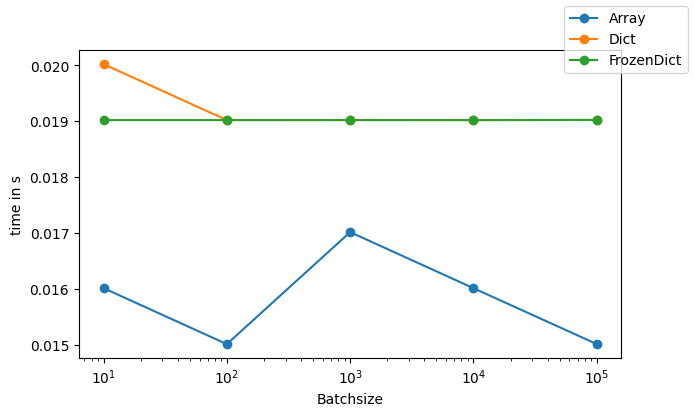

In [18]:
fig,ax=plt.subplots(1,1,figsize=(7,4))
names= ["Array","Dict","FrozenDict"]
sizes= [10,100,1000,10000,100000]
ax.plot(sizes,time_arr,label="Array",marker='o')
ax.plot(sizes,time_dict,label="Dict",marker='o')
ax.plot(sizes,time_frozendict,label="FrozenDict",marker='o')
ax.set_ylabel("time in s")
ax.set_xlabel("Batchsize")
ax.set_xscale('log')
fig.legend()
#ax.set_yscale('log')

In [19]:
import time
import random

#@jax.jit
def test22():
    time_arr=[]
    time_dict=[]
    time_frozendict=[]
    timeit_arr=[]
    timeit_dict=[]
    timeit_frozendict=[]
    for batch_size in [10,100,1000,10000,100000]:


        theta=jnp.full(batch_size,np.pi)
        omega=jnp.array(np.random.uniform(-1,1,batch_size))
        states_dict=dict({"theta":theta,"omega":omega})
        states_arr=jnp.array([theta,omega]).T
        
        act=np.random.uniform(-1,1,(batch_size,5000))
        #act2=[{"torque":act[:,i]} for i in range(act.shape[1])]
        
        print(f"Batch_Size:{batch_size} - timeit Array (const Action and State)")
        %timeit vmap_arr(act[:,0:1],states_arr)
        print(f"\nBatch_Size:{batch_size} - timeit dict (const Action and State)")
        %timeit vmap_dict(act[:,0:1],states_dict)
        print(f"\nBatch_Size:{batch_size} - timeit FrozenDict (const Action and State)")
        %timeit vmap_frozen_dict(act[:,0:1],states_dict)
        print("\n \n")

In [20]:
test22()

Batch_Size:10 - timeit Array (const Action and State)
3.16 µs ± 11.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

Batch_Size:10 - timeit dict (const Action and State)
3.84 µs ± 5.05 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

Batch_Size:10 - timeit FrozenDict (const Action and State)
3.85 µs ± 5.87 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

 

Batch_Size:100 - timeit Array (const Action and State)
3.19 µs ± 54 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

Batch_Size:100 - timeit dict (const Action and State)
3.82 µs ± 11.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

Batch_Size:100 - timeit FrozenDict (const Action and State)
3.82 µs ± 6.33 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

 

Batch_Size:1000 - timeit Array (const Action and State)
3.15 µs ± 5.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

Batch_Size:1000 - timeit dict (const Action and State)
3.82 µs ± 3.

In [43]:
import time
import random
@jax.jit
def test3():
    for batch_size in [10,100,1000,10000,100000]:


        theta=jnp.full(batch_size,np.pi)
        omega=jnp.array(np.random.uniform(-1,1,batch_size))
        states_dict=dict({"theta":theta,"omega":omega})
        states_arr=jnp.array([theta,omega]).T
        
        act=np.random.uniform(-1,1,(batch_size,5000))
        #act2=[{"torque":act[:,i]} for i in range(act.shape[1])]

        start_t = time.time()
        for i in range(5000):
            _= vmap_arr(act[:,i:i+1],states_arr)
        ex_time= time.time() -start_t
        #%timeit pend_arr.step(act[:,0:0+1],states_arr)
        print(f"Batch_Size:{batch_size} - Array Computation Time: {ex_time} \n")

        start_t = time.time()
        for i in range(5000):
            _ = vmap_dict(act[:,i:i+1],states_dict)
        ex_time= time.time() -start_t
        print(f"Batch_Size:{batch_size} - Dict Computation Time: {ex_time} \n")

        start_t = time.time()
        for i in range(5000):
            _ = vmap_frozen_dict(act[:,i:i+1],states_dict)
        ex_time= time.time() -start_t
        print(f"Batch_Size:{batch_size} - FrozenDict Computation Time: {ex_time} \n \n")
        

In [45]:
test3()

Batch_Size:10 - Array Computation Time: 0.6335752010345459 

Batch_Size:10 - Dict Computation Time: 0.7917194366455078 

Batch_Size:10 - FrozenDict Computation Time: 0.6956324577331543 
 

Batch_Size:100 - Array Computation Time: 0.7226574420928955 

Batch_Size:100 - Dict Computation Time: 0.7076430320739746 

Batch_Size:100 - FrozenDict Computation Time: 0.8557794094085693 
 

Batch_Size:1000 - Array Computation Time: 0.6415295600891113 

Batch_Size:1000 - Dict Computation Time: 0.7146496772766113 

Batch_Size:1000 - FrozenDict Computation Time: 0.8818168640136719 
 

Batch_Size:10000 - Array Computation Time: 0.6340901851654053 

Batch_Size:10000 - Dict Computation Time: 0.7256770133972168 

Batch_Size:10000 - FrozenDict Computation Time: 0.7216527462005615 
 

Batch_Size:100000 - Array Computation Time: 0.8482739925384521 

Batch_Size:100000 - Dict Computation Time: 0.721656084060669 

Batch_Size:100000 - FrozenDict Computation Time: 0.7236576080322266 
 



In [9]:
import time
import random
@jax.jit
def test_jit():
    for batch_size in [10,100,1000,10000,100000]:

        states_dict=[]
        states_dict_single=[]
        states_arr=[]
        states_arr_single=[]
        for _ in range(5000):
            theta=jnp.full(batch_size,np.pi)
            omega=jnp.array(np.random.uniform(-1,1,batch_size))
            states_dict.append(dict({"theta":theta,"omega":omega}))
            states_dict_single.append(dict({"theta":theta[0],"omega":omega[0]}))
            states_arr.append(jnp.array([theta,omega]).T)
            states_arr_single.append(jnp.array([theta[0],omega[0]]))
        
        act=np.random.uniform(-1,1,(batch_size,5000))
        #act2=[{"torque":act[:,i]} for i in range(act.shape[1])]

        start_t = time.time()
        for i in range(5000):
            _= vmap_arr(act[:,i:i+1],states_arr[i])
        ex_time= time.time() -start_t
        #%timeit pend_arr.step(act[:,0:0+1],states_arr)
        print(f"Batch_Size:{batch_size} - Array Computation Time: {ex_time} \n")

        start_t = time.time()
        for i in range(5000):
            _ = vmap_dict(act[:,i:i+1],states_dict[i])
        ex_time= time.time() -start_t
        print(f"Batch_Size:{batch_size} - Dict Computation Time: {ex_time} \n \n")
        
        # start_t = time.time()
        # for i in range(5000):
        #     _ = arr_step(act[:,i:i+1][0],states_arr[i])
        # ex_time= time.time() -start_t
        # #%timeit pend_dict.step(act2[0],states_dict)
        # print(f"Batch_Size:{batch_size} - Array Computation Time (without VMAP): {ex_time} \n ")

        # start_t = time.time()
        # for i in range(5000):
        #     _ = dict_step(act[:,i:i+1][0],states_dict_single[i])
        # ex_time= time.time() -start_t
        # #%timeit pend_dict.step(act2[0],states_dict)
        # print(f"Batch_Size:{batch_size} - Dict Computation Time (without VMAP): {ex_time} \n \n")

In [10]:
test_jit()

Batch_Size:10 - Array Computation Time: 0.9021492004394531 

Batch_Size:10 - Dict Computation Time: 0.7867152690887451 
 

Batch_Size:100 - Array Computation Time: 0.6676065921783447 

Batch_Size:100 - Dict Computation Time: 0.7612085342407227 
 

Batch_Size:1000 - Array Computation Time: 0.652592658996582 

Batch_Size:1000 - Dict Computation Time: 0.7556869983673096 
 

Batch_Size:10000 - Array Computation Time: 0.6475887298583984 

Batch_Size:10000 - Dict Computation Time: 0.7556869983673096 
 

Batch_Size:100000 - Array Computation Time: 0.6555960178375244 

Batch_Size:100000 - Dict Computation Time: 0.7672016620635986 
 



In [7]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
import chex
from abc import ABC
from abc import abstractmethod
from exciting_environments import spaces
import diffrax
from collections import OrderedDict


class CoreEnvironment(ABC):
    """
    Description:
        Core Structure of provided Environments.

    State Variables:
        Each environment has got a list of state variables that are defined by the physical system represented.

        Example:
            ``['theta', 'omega']``

    Action Variable:
        Each environment has got an action which is applied to the physical system represented.

        Example:
            ``['torque']``

    Observation Space(State Space):
        Type: Box()
            The Observation Space is nothing but the State Space of the pyhsical system.
            This Space is a normalized, continious, multidimensional box in [-1,1].

    Action Space:
        Type: Box()
            The action space of the environments are the action spaces of the physical systems.
            This Space is a continious, multidimensional box. 


    Initial State:
        Initial state values depend on the physical system.

    """

    def __init__(self, batch_size: int, tau: float = 1e-4, solver=diffrax.Euler(), reward_func=None):
        """
        Args:
            batch_size(int): Number of training examples utilized in one iteration.
            tau(float): Duration of one control step in seconds. Default: 1e-4.
        """
        self.batch_size = batch_size
        self.tau = tau
        self._solver = solver

        if reward_func:
            if self._test_rew_func(reward_func):
                self.reward_func = reward_func
        else:
            self.reward_func = self.default_reward_func

    # @property
    # def batch_size(self):
    #     """Returns the batch size of the environment setup."""
    #     return self._batch_size

    @property
    def default_reward_function(self):
        """Returns the default reward function for the given environment."""
        return self.default_reward_func

    # @batch_size.setter
    # def batch_size(self, batch_size):
    #     # If batchsize change, update the corresponding dimension
    #     self._batch_size = batch_size

    def sim_paras(self, static_params_, env_state_constraints_, env_max_actions_):
        """Creates or updates static parameters to fit batch_size.

        Creates/Updates:
            params : Model Parameters.
        """
        static_params = static_params_.copy()
        for key, value in static_params.items():
            if jnp.isscalar(value):
                static_params[key] = jnp.full((self.batch_size), value)
                # self.static_para_dims[key] = None
            # elif jnp.all(value == value[0]):
            #     self.static_params[key] = jnp.full(
            #         (self.batch_size, 1), value[0])
            else:
                assert len(
                    value) == self.batch_size, f"{key} is expected to be a scalar or a list with len(list)=batch_size"
                static_params[key] = jnp.array(value)
                # self.static_para_dims[key] = 0

        env_state_constraints = env_state_constraints_.copy()
        for key, value in env_state_constraints.items():
            if jnp.isscalar(value):
                env_state_constraints[key] = jnp.full((self.batch_size), value)
                # self.static_para_dims[key] = None
            # elif jnp.all(value == value[0]):
            #     self.static_params[key] = jnp.full(
            #         (self.batch_size, 1), value[0])
            else:
                assert len(
                    value) == self.batch_size, f"Constraint of {key} is expected to be a scalar or a list with len(list)=batch_size"
                env_state_constraints[key] = jnp.array(value)
                # self.static_para_dims[key] = 0

        env_max_actions = env_max_actions_.copy()
        for key, value in env_max_actions.items():
            if jnp.isscalar(value):
                env_max_actions[key] = jnp.full((self.batch_size), value)
                # self.static_para_dims[key] = None
            # elif jnp.all(value == value[0]):
            #     self.static_params[key] = jnp.full(
            #         (self.batch_size, 1), value[0])
            else:
                assert len(
                    value) == self.batch_size, f"Constraint of {key} is expected to be a scalar or a list with len(list)=batch_size"
                env_max_actions[key] = jnp.array(value)
                # self.static_para_dims[key] = 0

        return static_params, OrderedDict(env_state_constraints), OrderedDict(env_max_actions)

    # def solver(self):
    #     """Returns the current solver of the environment setup."""
    #     return self._solver

    # @solver.setter
    # def solver(self, solver):
    #     # TODO:check if solver exists in diffrax ?
    #     self._solver = solver

    def _test_rew_func(self, func):
        """Checks if passed reward function is compatible with given environment.

        Args:
            func(function): Reward function to test.

        Returns:
            compatible(bool): Environment compatibility.
        """
        try:
            out = func(
                jnp.zeros([self.batch_size, int(len(self.obs_description))]))
        except:
            raise Exception(
                "Reward function should be using obs matrix as only parameter")
        try:
            if out.shape != (self.batch_size, 1):
                raise Exception(
                    "Reward function should be returning vector in shape (batch_size,1)")
        except:
            raise Exception(
                "Reward function should be returning vector in shape (batch_size,1)")
        return True

    @partial(jax.jit, static_argnums=0)
    def step(self, action, states):
        """Addtional function in step execution to enable JAX jit.

        Args:
            states(ndarray(float)): State Matrix (shape=(batch_size,states)).
            action_norm(ndarray(float)): Action Matrix (shape=(batch_size,actions)).


        Returns:
            Multiple Outputs:

            observation(ndarray(float)): Observation/State Matrix (shape=(batch_size,states)).

            reward(ndarray(float)): Amount of reward received for the last step (shape=(batch_size,1)).

            terminated(bool): Flag, indicating if Agent has reached the terminal state.

            truncated(ndarray(bool)): Flag, indicating if state has gone out of bounds (shape=(batch_size,states)).

            {}: An empty dictionary for consistency with the OpenAi Gym interface.

        """
        # ode step
        states = jax.vmap(self._ode_exp_euler_step)(
            states, action, self.static_params)

        # observation
        # print(states)
        # print(self.env_state_constraints)
        #obs = jax.vmap(self.generate_observation)(
            #states, self.env_state_constraints)
        # reward
        #reward = jax.vmap(self.reward_func)(
            #obs, action, self.env_max_actions).reshape(-1, 1)

        # bound check
        #truncated = jax.vmap(self.generate_truncated)(
            #states, self.env_state_constraints)
        #terminated = jax.vmap(self.generate_terminated)(states, reward)

        #return obs, reward, terminated, truncated, states
        return {},{},{},{},states

    @property
    @abstractmethod
    def obs_description(self):
        """Returns a list of state names of all states in the observation (equal to state space)."""
        return self.states_description

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def default_reward_func(self, obs, action):
        """Returns the default RewardFunction of the environment."""
        return

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def generate_observation(self, states):
        """Returns states."""
        return states

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def generate_truncated(self, states):
        """Returns states."""
        return

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def generate_terminated(self, states, reward):
        """Returns states."""
        return

    @partial(jax.jit, static_argnums=0)
    @abstractmethod
    def _ode_exp_euler_step(self, states_norm, action_norm, state_normalizer,  action_normalizer, params):
        """Implementation of the system equations in the class with Explicit Euler.

        Args:
            states_norm(ndarray(float)): State Matrix (shape=(batch_size,states)).
            action_norm(ndarray(float)): Action Matrix (shape=(batch_size,actions)).


        Returns:
            states(ndarray(float)): State Matrix (shape=(batch_size,states)).

        """
        return

    @abstractmethod
    def reset(self, initial_values: jnp.ndarray = jnp.array([])):
        return


In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
import diffrax
from collections import OrderedDict


class Pendulum(CoreEnvironment):
    """
    State Variables:
        ``['theta', 'omega']``

    Action Variable:
        ``['torque']``

    Observation Space (State Space):
        Box(low=[-1, -1], high=[1, 1])    

    Action Space:
        Box(low=-1, high=1)

    Initial State:
        Unless chosen otherwise, theta equals 1(normalized to pi) and omega is set to zero.

    Example:
        >>> import jax
        >>> import exciting_environments as excenvs
        >>> 
        >>> # Create the environment
        >>> env= excenvs.make('Pendulum-v0',batch_size=2,l=2,m=4)
        >>> 
        >>> # Reset the environment with default initial values
        >>> env.reset()
        >>> 
        >>> # Sample a random action
        >>> action = env.action_space.sample(jax.random.PRNGKey(6))
        >>> 
        >>> # Perform step
        >>> obs,reward,terminated,truncated,info= env.step(action)
        >>> 

    """

    def __init__(self, batch_size: int = 8, l: float = 1, m: float = 1,  env_max_actions: dict = {"torque": 20}, solver=diffrax.Euler(), reward_func=None, g: float = 9.81, tau: float = 1e-4, env_state_constraints: dict = {"theta": np.pi, "omega": 10}):
        """
        Args:
            batch_size(int): Number of training examples utilized in one iteration. Default: 8
            l(float): Length of the pendulum. Default: 1
            m(float): Mass of the pendulum tip. Default: 1
            max_torque(float): Maximum torque that can be applied to the system as action. Default: 20 
            reward_func(function): Reward function for training. Needs Observation-Matrix and Action as Parameters. 
                                    Default: None (default_reward_func from class) 
            g(float): Gravitational acceleration. Default: 9.81
            tau(float): Duration of one control step in seconds. Default: 1e-4.
            constraints(list): Constraints for state ['omega'] (list with length 1). Default: [10]

        Note: l,m and max_torque can also be passed as lists with the length of the batch_size to set different parameters per batch. In addition to that constraints can also be passed as a list of lists with length 1 to set different constraints per batch.  
        """
        self.env_states_name = ["theta", "omega"]
        self.env_actions_name = ["torque"]

        self.env_states_initials = {"theta": np.pi, "omega": 0}

        super().__init__(batch_size=batch_size, tau=tau,
                         solver=solver, reward_func=reward_func)

        self.static_params, self.env_state_constraints, self.env_max_actions = self.sim_paras(
            {"l": l, "m": m, "g": g}, env_state_constraints, env_max_actions)

    @partial(jax.jit, static_argnums=0)
    def _ode_exp_euler_step(self, states, action, static_params):

        env_states = states
        args = (action, static_params)

        def vector_field(t, y, args):
            theta, omega = y
            torque, params = args
            d_omega = (torque["torque"]+params["l"]*params["m"]*params["g"]
                       * jnp.sin(theta)) / (params["m"] * (params["l"])**2)
            d_theta = omega
            d_y = d_theta, d_omega  # [0]  # d_theta, d_omega
            return d_y

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.tau
        y0 = tuple([env_states["theta"], env_states["omega"]])
        env_state = self._solver.init(term, t0, t1, y0, args)
        y, _, _, env_state, _ = self._solver.step(
            term, t0, t1, y0, args, env_state, made_jump=False)

        theta_k1 = y[0]
        omega_k1 = y[1]
        theta_k1 = ((theta_k1+jnp.pi) % (2*jnp.pi))-jnp.pi

        # env_states_k1 = jnp.hstack((
        #     theta_k1,
        #     omega_k1,
        # ))
        env_states_k1 = OrderedDict([("theta", theta_k1), ("omega", omega_k1)])

        # env_states_k1_norm = env_states_k1/env_state_normalizer

        return env_states_k1

    @partial(jax.jit, static_argnums=0)
    def default_reward_func(self, obs, action, env_max_actions):
        return (obs[0])**2 + 0.1*(obs[1])**2 + 0.1*(action["torque"]/env_max_actions["torque"])**2

    @partial(jax.jit, static_argnums=0)
    def generate_observation(self, states, env_state_constraints):
        """Returns states."""
        return (jnp.array(list(states.values()))*(jnp.array(list(env_state_constraints.values())))**(-1)).T  #

    @partial(jax.jit, static_argnums=0)
    def generate_truncated(self, states, env_state_constraints):
        """Returns states."""
        return jnp.abs((jnp.array(list(states.values()))/jnp.array(list(env_state_constraints.values()))).T) > 1

    @partial(jax.jit, static_argnums=0)
    def generate_terminated(self, states, reward):
        """Returns states."""
        return reward == 0

    @property
    def obs_description(self):
        return self.env_states_name

    def reset(self, initial_values: jnp.ndarray = jnp.array([])):
        # TODO
        # if initial_values.any() != False:
        #     assert initial_values.shape[
        #         0] == self.batch_size, f"number of rows is expected to be batch_size, got: {initial_values.shape[0]}"
        #     assert initial_values.shape[1] == len(
        #         self.obs_description), f"number of columns is expected to be amount obs_entries: {len(self.obs_description)}, got: {initial_values.shape[0]}"
        #     states = initial_values
        # else:
        #     states = jnp.tile(
        #         jnp.array(self.env_state_initials), (self.batch_size, 1))

        # obs = self.generate_observation(states)

        return  # obs, states


In [5]:
import time
import random
for batch_size in [10,100,1000,10000,100000]:
    w1=GymWrapper.fromName('Pendulum-v0',batch_size=batch_size,l=[np.random.uniform(0,2) for _ in range(batch_size)])
    act=[w1.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))) for _ in range(10000)]
    w1.reset(random_key=jax.random.PRNGKey(9))
    start_t = time.time()
    for i in range(10000):
        #obs,reward,a,b,_ = env.step(env.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))))
        obs1,reward,a,b,_ = w1.step(act[i])
    ex_time= time.time() -start_t
    print(f"Batch_Size:{batch_size} - diffrax Computation Time: {ex_time} \n")

Batch_Size:10 - diffrax Computation Time: 0.24822568893432617 

Batch_Size:100 - diffrax Computation Time: 0.2742495536804199 

Batch_Size:1000 - diffrax Computation Time: 0.3493180274963379 

Batch_Size:10000 - diffrax Computation Time: 1.2011053562164307 

Batch_Size:100000 - diffrax Computation Time: 18.591322660446167 



In [5]:
import time
import random
batch_size=5
sim_len=5000
w1=GymWrapper.fromName('Pendulum-v0',batch_size=batch_size,solver=diffrax.Euler(),l=[1,1,1,1,1])
w2=GymWrapper.fromName('Pendulum-v0',batch_size=batch_size,solver=diffrax.Dopri5())
act1=[w1.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))) for _ in range(sim_len)]
act1= np.zeros_like(act1)
obs1_init,_=w1.reset(random_key=jax.random.PRNGKey(6))
obs2_init,_=w2.reset(random_key=jax.random.PRNGKey(6))
data_1=[]
data_2=[]
for i in range(sim_len):
    obs1,reward,a,b,_ = w1.step(act1[i])
    obs2,reward,a,b,_ = w2.step(act1[i])
    data_1.append(np.array(obs1)[1,0]*jnp.pi)
    data_2.append(np.array(obs2)[1,0]*jnp.pi)

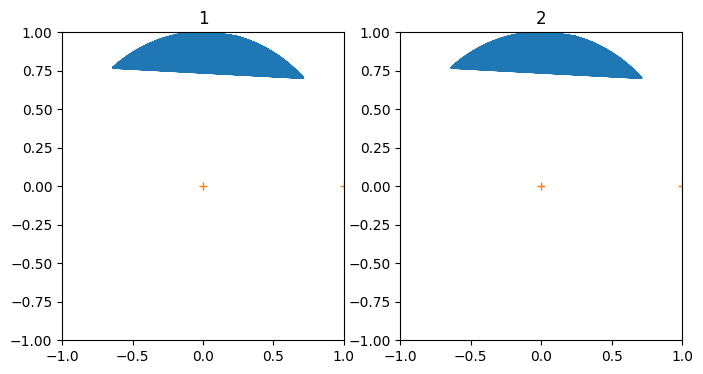

In [6]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,2,figsize=(8,4))

axes[0].plot(np.sin(data_1),np.cos(data_1))
axes[1].plot(np.sin(data_2),np.cos(data_2))
axes[0].set_title("1")
axes[1].set_title("2")
axes[0].set_xlim(-1,1)
axes[0].set_ylim(-1,1)
axes[1].set_xlim(-1,1)
axes[1].set_ylim(-1,1)
axes[0].plot([0,0], marker='+', ls= 'none')
axes[1].plot([0,0], marker='+', ls= 'none')

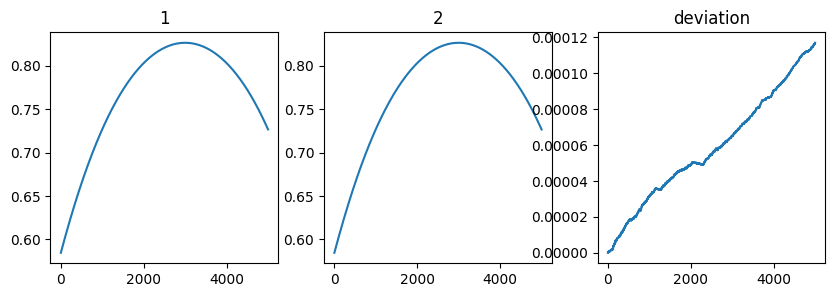

In [8]:
fig,axes = plt.subplots(1,3,figsize=(10,3))

axes[0].plot(np.sin(data_1))
axes[1].plot(np.sin(data_2))
axes[0].set_title("1")
axes[1].set_title("2")
axes[2].set_title("deviation")
axes[2].plot(np.sin(data_1)-np.sin(data_2))

In [3]:
import time
import random
for batch_size in [10,100,1000,10000,100000]:
    w1=GymWrapper.fromName('MassSpringDamper-v0',batch_size=batch_size)
    act=[w1.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))) for _ in range(10000)]
    #w1.reset(random_key=jax.random.PRNGKey(9))
    start_t = time.time()
    for i in range(10000):
        #obs,reward,a,b,_ = env.step(env.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))))
        obs1,reward,a,b,_ = w1.step(act[i])
    ex_time= time.time() -start_t
    print(f"Batch_Size:{batch_size} - diffrax Computation Time: {ex_time} \n")

Batch_Size:10 - diffrax Computation Time: 0.27625083923339844 

Batch_Size:100 - diffrax Computation Time: 0.2702465057373047 

Batch_Size:1000 - diffrax Computation Time: 0.34631800651550293 

Batch_Size:10000 - diffrax Computation Time: 0.6405835151672363 

Batch_Size:100000 - diffrax Computation Time: 3.4414219856262207 



In [5]:
import time
import random
batch_size=5
sim_len=5000
w1=GymWrapper.fromName('MassSpringDamper-v0',batch_size=batch_size,solver=diffrax.Euler())
w2=GymWrapper.fromName('MassSpringDamper-v0',batch_size=batch_size,solver=diffrax.Dopri5())
act1=[w1.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))) for _ in range(sim_len)]
act1= np.zeros_like(act1)
obs1_init,_=w1.reset(random_key=jax.random.PRNGKey(6))
obs2_init,_=w2.reset(random_key=jax.random.PRNGKey(6))
data_1=[]
data_2=[]
for i in range(sim_len):
    obs1,reward,a,b,_ = w1.step(act1[i])
    obs2,reward,a,b,_ = w2.step(act1[i])
    data_1.append(np.array(obs1)[1,0])
    data_2.append(np.array(obs2)[1,0])

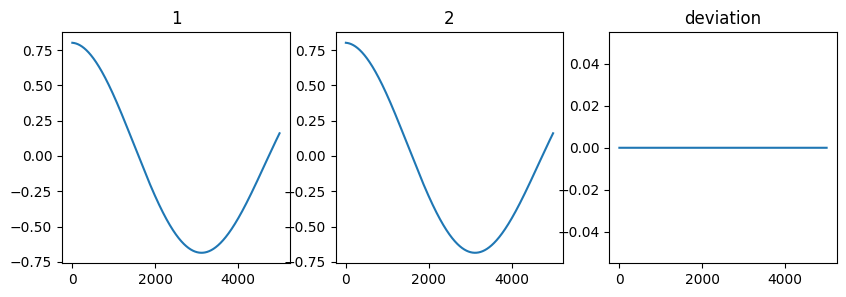

In [6]:
fig,axes = plt.subplots(1,3,figsize=(10,3))

axes[0].plot((data_1))
axes[1].plot((data_2))
axes[0].set_title("1")
axes[1].set_title("2")
axes[2].set_title("deviation")
axes[2].plot(np.array(data_1)-np.array(data_2))

In [2]:
import time
import random
for batch_size in [10,100,1000,10000,100000]:
    w1=GymWrapper.fromName('CartPole-v0',batch_size=batch_size)
    act=[w1.env.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))) for _ in range(10000)]
    w1.reset(random_key=jax.random.PRNGKey(9))
    start_t = time.time()
    for i in range(10000):
        #obs,reward,a,b,_ = env.step(env.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))))
        obs1,reward,a,b,_ = w1.step(act[i])
    ex_time= time.time() -start_t
    print(f"Batch_Size:{batch_size} - diffrax Computation Time: {ex_time} \n")

Batch_Size:10 - diffrax Computation Time: 0.19117379188537598 

Batch_Size:100 - diffrax Computation Time: 0.21419525146484375 

Batch_Size:1000 - diffrax Computation Time: 0.4884450435638428 

Batch_Size:10000 - diffrax Computation Time: 4.017655849456787 

Batch_Size:100000 - diffrax Computation Time: 38.2498574256897 



In [7]:
import time
import random
batch_size=5
sim_len=5000
w1=GymWrapper.fromName('CartPole-v0',batch_size=batch_size,solver=diffrax.Euler())
w2=GymWrapper.fromName('CartPole-v0',batch_size=batch_size,solver=diffrax.Dopri5())
act1=[w1.env.action_space.sample(jax.random.PRNGKey(random.randint(0,100000))) for _ in range(sim_len)]
act1= np.zeros_like(act1)
obs1_init,_=w1.reset(random_key=jax.random.PRNGKey(6))
obs2_init,_=w2.reset(random_key=jax.random.PRNGKey(6))
data_1=[]
data_2=[]
for i in range(sim_len):
    obs1,reward,a,b,_ = w1.step(act1[i])
    obs2,reward,a,b,_ = w2.step(act1[i])
    data_1.append(np.array(obs1)[1,0])
    data_2.append(np.array(obs2)[1,0])

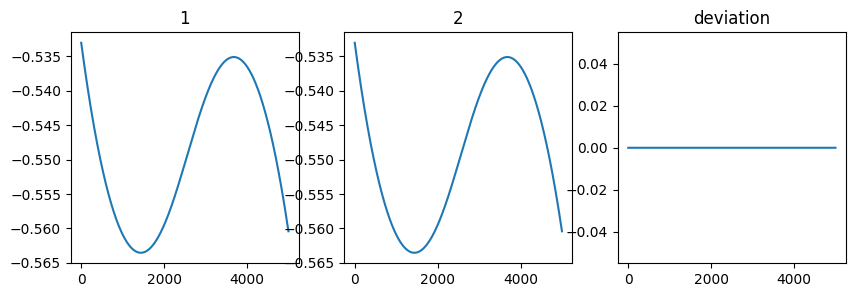

In [8]:
fig,axes = plt.subplots(1,3,figsize=(10,3))

axes[0].plot((data_1))
axes[1].plot((data_2))
axes[0].set_title("1")
axes[1].set_title("2")
axes[2].set_title("deviation")
axes[2].plot(np.array(data_1)-np.array(data_2))

In [30]:
w1=GymWrapper.fromName('Pendulum-v0',batch_size=batch_size,solver=diffrax.Euler())

In [31]:
w1.step(jnp.array([0,0,0,0,0]).reshape(-1,1))

(Array([[3.1415927e-01, 1.0002432e-04],
        [3.1415927e-01, 1.0002432e-04],
        [3.1415927e-01, 1.0002432e-04],
        [3.1415927e-01, 1.0002432e-04],
        [3.1415927e-01, 1.0002432e-04]], dtype=float32),
 Array([[0.09869605],
        [0.09869605],
        [0.09869605],
        [0.09869605],
        [0.09869605]], dtype=float32),
 Array([[False],
        [False],
        [False],
        [False],
        [False]], dtype=bool),
 Array([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]], dtype=bool),
 {})